In [85]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [87]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [88]:
! chmod 600 ~/.kaggle/kaggle.json

In [89]:
!pip install wandb -qU

In [90]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [91]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [92]:
import contextlib
import sys
import os

# Define SuppressOutput context manager
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [93]:
# model_inference.ipynb
import pandas as pd
import numpy as np
import wandb
import joblib
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Initialize WandB for inference
wandb.init(project="walmart-sales-forecasting", name="Prophet_Inference")

print("=== WALMART SALES FORECASTING - PROPHET INFERENCE ===")
print("Loading test data...")

# Load test data and sample submission
test_df = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

# Also load reference data needed for preprocessing
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")

print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Test date range: {test_df['Date'].min()} to {test_df['Date'].max()}")

# Log inference start info
wandb.log({
    "inference_started": True,
    "test_samples": len(test_df),
    "test_stores": test_df['Store'].nunique(),
    "test_departments": test_df['Dept'].nunique(),
    "test_date_range": f"{test_df['Date'].min()} to {test_df['Date'].max()}"
})

print("Data loaded successfully!")

=== WALMART SALES FORECASTING - PROPHET INFERENCE ===
Loading test data...
Test data shape: (115064, 4)
Sample submission shape: (115064, 2)
Test date range: 2012-11-02 to 2013-07-26
Data loaded successfully!


In [94]:
print("=== DOWNLOADING BEST PROPHET MODEL ===")

# Download the best Prophet pipeline from WandB Artifacts
try:
    print("Searching for latest Prophet pipeline artifact...")

    # Get the latest version of the prophet_pipeline artifact
    artifact = wandb.use_artifact('prophet_pipeline:latest', type='model')
    artifact_dir = artifact.download()

    print(f"Artifact downloaded to: {artifact_dir}")

    # Find the pipeline file in the downloaded directory
    pipeline_file = None
    for file in os.listdir(artifact_dir):
        if file.endswith('.pkl') and 'prophet_pipeline' in file:
            pipeline_file = os.path.join(artifact_dir, file)
            break

    if pipeline_file:
        # Load the pipeline with dill
        print(f"Loading pipeline from: {pipeline_file}")
        import dill
        with open(pipeline_file, 'rb') as f:
            prophet_pipeline = dill.load(f)
        print("✅ Pipeline loaded successfully from WandB artifact!")

        # Log artifact metadata
        artifact_metadata = artifact.metadata
        print(f"Model metadata: {artifact_metadata}")

        wandb.log({
            "model_loaded_from": "wandb_artifact",
            "artifact_version": artifact.version,
            "model_metadata": artifact_metadata
        })

    else:
        raise FileNotFoundError("No pipeline file found in artifact")

except Exception as e:
    print(f"❌ Error downloading from WandB artifacts: {e}")
    print("🔄 Attempting to load from local backup...")

    # Fallback: try to find local pipeline file
    import glob
    local_files = glob.glob("prophet_pipeline_*.pkl")

    if local_files:
        # Use the most recent local file
        pipeline_file = max(local_files, key=os.path.getctime)
        import dill
        with open(pipeline_file, 'rb') as f:
            prophet_pipeline = dill.load(f)
        print(f"✅ Loaded local pipeline: {pipeline_file}")

        wandb.log({
            "model_loaded_from": "local_backup",
            "local_file": pipeline_file
        })
    else:
        raise FileNotFoundError("❌ No pipeline file found locally or in WandB artifacts")

print("Model loading completed!")

# Verify the pipeline is properly loaded
print(f"Pipeline type: {type(prophet_pipeline)}")
print(f"Pipeline has model: {hasattr(prophet_pipeline, 'model') and prophet_pipeline.model is not None}")
if hasattr(prophet_pipeline, 'model') and prophet_pipeline.model is not None:
    print(f"Number of trained models: {len(prophet_pipeline.model.models)}")

=== DOWNLOADING BEST PROPHET MODEL ===
Searching for latest Prophet pipeline artifact...


wandb: Downloading large artifact prophet_pipeline:latest, 84.93MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4 (204.6MB/s)


Artifact downloaded to: /content/artifacts/prophet_pipeline:v2
Loading pipeline from: /content/artifacts/prophet_pipeline:v2/prophet_pipeline_20250706_172847.pkl
✅ Pipeline loaded successfully from WandB artifact!
Model metadata: {'n_models': 3167, 'timestamp': '20250706_172847', 'train_mae': 1431.0793797392523, 'model_type': 'Prophet', 'train_rmse': 4089.3252361795353, 'best_params': {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}}
Model loading completed!
Pipeline type: <class '__main__.WalmartProphetPipeline'>
Pipeline has model: True
Number of trained models: 3167


In [95]:
print("=== PREPROCESSING TEST DATA ===")

# The pipeline should handle preprocessing automatically, but let's verify the data looks good
print("Test data info before preprocessing:")
print(f"Shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")
print(f"Date column type: {test_df['Date'].dtype}")
print(f"Sample data:")
print(test_df.head())

# Check for any obvious issues
print(f"Missing values in test data: {test_df.isnull().sum().sum()}")
print(f"Unique stores: {test_df['Store'].nunique()}")
print(f"Unique departments: {test_df['Dept'].nunique()}")

# Log preprocessing info
wandb.log({
    "test_preprocessing_started": True,
    "test_missing_values": test_df.isnull().sum().sum(),
    "test_unique_stores": test_df['Store'].nunique(),
    "test_unique_departments": test_df['Dept'].nunique()
})

print("✅ Test data ready for prediction!")

=== PREPROCESSING TEST DATA ===
Test data info before preprocessing:
Shape: (115064, 4)
Columns: ['Store', 'Dept', 'Date', 'IsHoliday']
Date column type: object
Sample data:
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Missing values in test data: 0
Unique stores: 45
Unique departments: 81
✅ Test data ready for prediction!


In [96]:
print("=== MAKING PREDICTIONS ===")

# Make predictions on test set using the pipeline
print("Starting prediction process...")
print("This may take several minutes due to the number of store-department combinations...")

try:
    # The pipeline handles all preprocessing and prediction
    test_predictions = prophet_pipeline.predict(test_df)

    print("✅ Predictions completed successfully!")

    # Analyze predictions
    print(f"\n=== PREDICTION ANALYSIS ===")
    print(f"Total predictions: {len(test_predictions)}")
    print(f"Mean prediction: ${np.mean(test_predictions):,.2f}")
    print(f"Median prediction: ${np.median(test_predictions):,.2f}")
    print(f"Std prediction: ${np.std(test_predictions):,.2f}")
    print(f"Min prediction: ${np.min(test_predictions):,.2f}")
    print(f"Max prediction: ${np.max(test_predictions):,.2f}")

    # Check for any unusual values
    negative_predictions = (test_predictions < 0).sum()
    zero_predictions = (test_predictions == 0).sum()
    very_high_predictions = (test_predictions > 100000).sum()

    print(f"\n=== PREDICTION QUALITY CHECKS ===")
    print(f"Negative predictions: {negative_predictions}")
    print(f"Zero predictions: {zero_predictions}")
    print(f"Very high predictions (>$100k): {very_high_predictions}")

    # Log prediction statistics
    wandb.log({
        "predictions_completed": True,
        "total_predictions": len(test_predictions),
        "mean_prediction": np.mean(test_predictions),
        "median_prediction": np.median(test_predictions),
        "std_prediction": np.std(test_predictions),
        "min_prediction": np.min(test_predictions),
        "max_prediction": np.max(test_predictions),
        "negative_predictions": negative_predictions,
        "zero_predictions": zero_predictions,
        "very_high_predictions": very_high_predictions
    })

    # Handle any negative predictions by setting them to a small positive value
    if negative_predictions > 0:
        print(f"⚠️ Setting {negative_predictions} negative predictions to $1")
        test_predictions = np.maximum(test_predictions, 1.0)

except Exception as e:
    print(f"❌ Error during prediction: {e}")
    raise e

print("Prediction process completed!")

=== MAKING PREDICTIONS ===
Starting prediction process...
This may take several minutes due to the number of store-department combinations...
Making predictions for 3169 store-department combinations...
Prediction progress: 0 combinations processed...
Prediction progress: 100 combinations processed...
Prediction progress: 200 combinations processed...
Prediction progress: 300 combinations processed...
Prediction progress: 400 combinations processed...
Prediction progress: 500 combinations processed...
Prediction progress: 600 combinations processed...
Prediction progress: 700 combinations processed...
Prediction progress: 800 combinations processed...
Prediction progress: 900 combinations processed...
Prediction progress: 1000 combinations processed...
Prediction progress: 1100 combinations processed...
Prediction progress: 1200 combinations processed...
Prediction progress: 1300 combinations processed...
Prediction progress: 1400 combinations processed...
Prediction progress: 1500 com

In [97]:
print("=== CREATING SUBMISSION FILE ===")

# Create final submission
final_submission = sample_submission.copy()
final_submission['Weekly_Sales'] = test_predictions

# Validate submission format
print("Validating submission format...")
print(f"Submission shape: {final_submission.shape}")
print(f"Required shape: {sample_submission.shape}")
print(f"Columns match: {list(final_submission.columns) == list(sample_submission.columns)}")

# Check for missing values in submission
submission_missing = final_submission.isnull().sum().sum()
print(f"Missing values in submission: {submission_missing}")

if submission_missing > 0:
    print("⚠️ Found missing values in submission. Filling with median...")
    final_submission['Weekly_Sales'] = final_submission['Weekly_Sales'].fillna(
        final_submission['Weekly_Sales'].median()
    )

# Final validation
print(f"\n=== FINAL SUBMISSION VALIDATION ===")
print(f"All predictions are numeric: {pd.api.types.is_numeric_dtype(final_submission['Weekly_Sales'])}")
print(f"No missing values: {final_submission['Weekly_Sales'].isnull().sum() == 0}")
print(f"All predictions positive: {(final_submission['Weekly_Sales'] > 0).all()}")

# Show sample of submission
print(f"\nSample submission:")
print(final_submission.head(10))

# Save final submission
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
final_submission_filename = f'final_prophet_submission_{timestamp}.csv'
final_submission.to_csv(final_submission_filename, index=False)

print(f"✅ Final submission saved as: {final_submission_filename}")

# Log submission creation info
wandb.log({
    "submission_created": True,
    "submission_filename": final_submission_filename,
    "submission_valid": True,
    "submission_size": len(final_submission)
})

=== CREATING SUBMISSION FILE ===
Validating submission format...
Submission shape: (115064, 2)
Required shape: (115064, 2)
Columns match: True
Missing values in submission: 0

=== FINAL SUBMISSION VALIDATION ===
All predictions are numeric: True
No missing values: True
All predictions positive: True

Sample submission:
               Id  Weekly_Sales
0  1_1_2012-11-02  33808.825648
1  1_1_2012-11-09  27921.346387
2  1_1_2012-11-16  19773.489994
3  1_1_2012-11-23  16511.141433
4  1_1_2012-11-30  22559.200399
5  1_1_2012-12-07  33961.325196
6  1_1_2012-12-14  42967.322307
7  1_1_2012-12-21  42388.924698
8  1_1_2012-12-28  33545.825957
9  1_1_2013-01-04  21687.050782
✅ Final submission saved as: final_prophet_submission_20250706_180100.csv


=== CREATING WANDB ARTIFACTS ===
✅ Submission artifact created successfully!


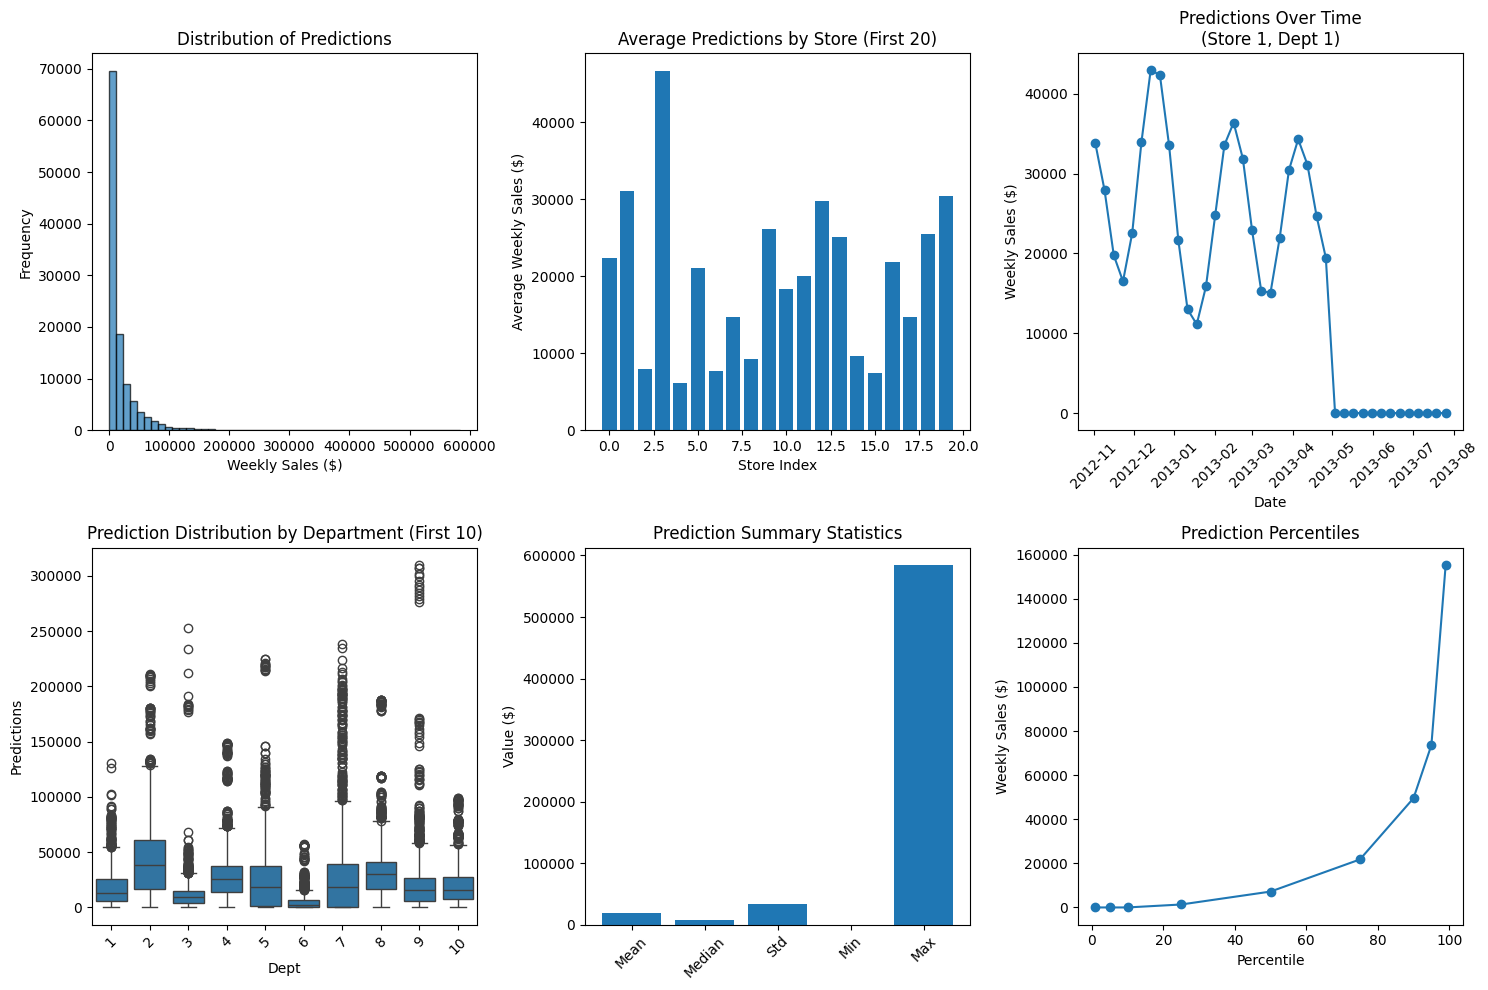

=== INFERENCE COMPLETE ===
✅ Submission file ready: final_prophet_submission_20250706_180100.csv
📊 Analysis plots saved and logged to WandB
🚀 Upload final_prophet_submission_20250706_180100.csv to Kaggle for evaluation!
🔗 Check your WandB dashboard for detailed logs and artifacts


max_prediction,▁
mean_prediction,▁
median_prediction,▁
min_prediction,▁
negative_predictions,▁
std_prediction,▁
submission_size,▁
test_departments,▁
test_missing_values,▁
test_samples,▁
test_stores,▁


In [98]:
print("=== CREATING WANDB ARTIFACTS ===")

# Create artifact for final submission
final_submission_artifact = wandb.Artifact(
    name="final_prophet_submission",
    type="result",
    description=f"Final Prophet submission for Kaggle evaluation - {timestamp}",
    metadata={
        "model_type": "Prophet",
        "submission_timestamp": timestamp,
        "total_predictions": len(test_predictions),
        "mean_prediction": float(np.mean(test_predictions)),
        "prediction_range": f"${np.min(test_predictions):.2f} - ${np.max(test_predictions):.2f}"
    }
)

# Add the submission file to the artifact
final_submission_artifact.add_file(final_submission_filename)

# Log the artifact
wandb.log_artifact(final_submission_artifact)

print("✅ Submission artifact created successfully!")

# Create visualization of predictions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Plot 1: Distribution of predictions
plt.subplot(2, 3, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Weekly Sales ($)')
plt.ylabel('Frequency')

# Plot 2: Predictions by Store (sample)
plt.subplot(2, 3, 2)
store_means = []
store_ids = []
for store in sorted(test_df['Store'].unique())[:20]:  # First 20 stores
    store_preds = test_predictions[test_df['Store'] == store]
    store_means.append(np.mean(store_preds))
    store_ids.append(store)

plt.bar(range(len(store_ids)), store_means)
plt.title('Average Predictions by Store (First 20)')
plt.xlabel('Store Index')
plt.ylabel('Average Weekly Sales ($)')

# Plot 3: Predictions over time (sample)
plt.subplot(2, 3, 3)
test_df_with_preds = test_df.copy()
test_df_with_preds['Predictions'] = test_predictions
test_df_with_preds['Date'] = pd.to_datetime(test_df_with_preds['Date'])

# Sample one store-dept combination
sample_store = test_df['Store'].iloc[0]
sample_dept = test_df['Dept'].iloc[0]
sample_data = test_df_with_preds[
    (test_df_with_preds['Store'] == sample_store) &
    (test_df_with_preds['Dept'] == sample_dept)
].sort_values('Date')

plt.plot(sample_data['Date'], sample_data['Predictions'], marker='o')
plt.title(f'Predictions Over Time\n(Store {sample_store}, Dept {sample_dept})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.xticks(rotation=45)

# Plot 4: Box plot by Department (sample)
plt.subplot(2, 3, 4)
dept_sample = []
pred_sample = []
for dept in sorted(test_df['Dept'].unique())[:10]:  # First 10 departments
    dept_preds = test_predictions[test_df['Dept'] == dept]
    dept_sample.extend([dept] * len(dept_preds))
    pred_sample.extend(dept_preds)

df_for_plot = pd.DataFrame({'Dept': dept_sample, 'Predictions': pred_sample})
sns.boxplot(data=df_for_plot, x='Dept', y='Predictions')
plt.title('Prediction Distribution by Department (First 10)')
plt.xticks(rotation=45)

# Plot 5: Summary statistics
plt.subplot(2, 3, 5)
stats = [
    np.mean(test_predictions),
    np.median(test_predictions),
    np.std(test_predictions),
    np.min(test_predictions),
    np.max(test_predictions)
]
stat_names = ['Mean', 'Median', 'Std', 'Min', 'Max']
plt.bar(stat_names, stats)
plt.title('Prediction Summary Statistics')
plt.ylabel('Value ($)')
plt.xticks(rotation=45)

# Plot 6: Prediction range by percentiles
plt.subplot(2, 3, 6)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
perc_values = np.percentile(test_predictions, percentiles)
plt.plot(percentiles, perc_values, marker='o')
plt.title('Prediction Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Weekly Sales ($)')

plt.tight_layout()
plt.savefig('prophet_inference_analysis.png', dpi=300, bbox_inches='tight')
wandb.log({"inference_analysis": wandb.Image('prophet_inference_analysis.png')})
plt.show()

# Final logging
wandb.log({
    "inference_completed": True,
    "final_submission_ready": True,
    "kaggle_submission_file": final_submission_filename,
    "model_performance_estimated": "Check Kaggle leaderboard after submission"
})

print("=== INFERENCE COMPLETE ===")
print(f"✅ Submission file ready: {final_submission_filename}")
print(f"📊 Analysis plots saved and logged to WandB")
print(f"🚀 Upload {final_submission_filename} to Kaggle for evaluation!")
print(f"🔗 Check your WandB dashboard for detailed logs and artifacts")

wandb.finish()

In [99]:
# Optional: Quick verification block
print("=== QUICK SUBMISSION VERIFICATION ===")

# Load and verify the saved submission
verification_df = pd.read_csv(final_submission_filename)

print(f"Saved submission shape: {verification_df.shape}")
print(f"Sample of saved submission:")
print(verification_df.head())

# Check file size
import os
file_size = os.path.getsize(final_submission_filename) / (1024 * 1024)  # MB
print(f"File size: {file_size:.2f} MB")

# Final checks
print(f"✅ File exists: {os.path.exists(final_submission_filename)}")
print(f"✅ Correct columns: {'Id' in verification_df.columns and 'Weekly_Sales' in verification_df.columns}")
print(f"✅ No missing values: {verification_df.isnull().sum().sum() == 0}")
print(f"✅ All numeric predictions: {pd.api.types.is_numeric_dtype(verification_df['Weekly_Sales'])}")

print("\n🎉 READY FOR KAGGLE SUBMISSION! 🎉")

=== QUICK SUBMISSION VERIFICATION ===
Saved submission shape: (115064, 2)
Sample of saved submission:
               Id  Weekly_Sales
0  1_1_2012-11-02  33808.825648
1  1_1_2012-11-09  27921.346387
2  1_1_2012-11-16  19773.489994
3  1_1_2012-11-23  16511.141433
4  1_1_2012-11-30  22559.200399
File size: 3.66 MB
✅ File exists: True
✅ Correct columns: True
✅ No missing values: True
✅ All numeric predictions: True

🎉 READY FOR KAGGLE SUBMISSION! 🎉
